In [ ]:
pip install torch torchvision scikit-learn


Accuracy: 0.8361

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.78      0.97      0.86        33

    accuracy                           0.84        61
   macro avg       0.87      0.82      0.83        61
weighted avg       0.86      0.84      0.83        61



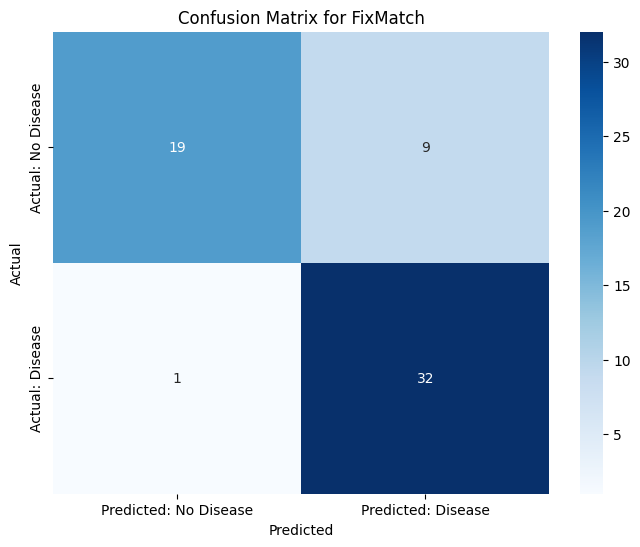

Confusion Matrix:
 [[19  9]
 [ 1 32]]


In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

# Load dataset
df = pd.read_csv("/heart.csv")

# Define target and features
y = df["target"].values
X = df.drop(["target"], axis=1).values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)

# Create a custom dataset
class HeartDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = HeartDataset(X_train, y_train)
test_dataset = HeartDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model, loss function, and optimizer
model = SimpleNN(input_size=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.float().to(device), labels.float().to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Train the model
train(model, train_loader, optimizer, criterion, epochs=50)

# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).cpu().numpy()
            y_true.extend(labels.numpy())
            y_pred.extend(predicted)

    return np.array(y_true), np.array(y_pred).flatten()

# Evaluate the model
y_true, y_pred = evaluate(model, test_loader)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: No Disease', 'Predicted: Disease'],
            yticklabels=['Actual: No Disease', 'Actual: Disease'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for FixMatch')
plt.show()

# Print the confusion matrix (optional)
print("Confusion Matrix:\n", cm)
